# Introduction

This problem mirrors the identification of the control gains used in standing from:

> Park, Sukyung, Fay B. Horak, and Arthur D. Kuo. "Postural Feedback Responses Scale with Biomechanical Constraints in Human Standing." Experimental Brain Research 154, no. 4 (February 1, 2004): 417-27. doi:10.1007/s00221-003-1674-3.

except that we identify from much longer times series and use methods that are order's of magnitude faster. The model is shown in the figure below:

<img src="free-body-diagram.svg" width=300px />

# Imports

In [1]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from opty.direct_collocation import Problem
from opty.utils import sum_of_sines, parse_free

from model import PlanarStandingHumanOnMovingPlatform

The following will all the symbolics to be rendered correctly.

In [2]:
me.init_vprinting(use_latex='mathjax')

This causes the matplotlib plots to show inline in the notebook and sets the default figure size.

In [3]:
%matplotlib inline
figsize(12.0, 9.0)

# Derive the symbolic model

The model is derived using PyDy and SymPy mechanics. This class exercises the APIs behind the scene to generate the equations of motion of the system. This model also has scaling feature that is useful for good convergence of the NLP problem.

In [4]:
model = PlanarStandingHumanOnMovingPlatform(unscaled_gain=0.5)
model.derive()

The model has four states, an angle and angular rate for the ankle and hip.

In [5]:
model.states()

[θₐ, θ_h, ωₐ, ω_h]

The model constants are shown below. The $s$ terms are the scaled gains.

In [6]:
model.closed_loop_par_map

{I_L: 1.79917382349, I_T: 2.48116350633, d_L: 0.571598315274, d_T: 0.314491823
529, g: 9.81, l_L: 0.878, m_L: 32.125955184, m_T: 48.8305665951, s₀₀: 1900.0, 
s₀₁: 350.0, s₀₂: 370.0, s₀₃: 100.0, s₁₀: 90.0, s₁₁: 580.0, s₁₂: 120.0, s₁₃: 52
.0}

The full state feedback matrix has this form:

In [7]:
model.gain_matrix

⎡k₀₀  k₀₁  k₀₂  k₀₃⎤
⎢                  ⎥
⎣k₁₀  k₁₁  k₁₂  k₁₃⎦

Finally the implicit form of the equations of motion can be output:

In [8]:
model.first_order_implicit()

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢d_L⋅g⋅m_L⋅sin(θₐ) + d_L⋅m_L⋅a⋅cos(θₐ) + d_T⋅g⋅m_T⋅sin(θₐ + θ_h) + d_T⋅l_L⋅m_T
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                                                              
                                                                              
                                                                              
                                                   

# Generate "Measured" Data

We will generate data for a duration of 20 seconds with the measurement sampling matching the discretization of the collocation problem, both at 200 hz.

In [9]:
num_nodes = 4000
duration = 20.0
interval = duration / (num_nodes - 1)

time = np.linspace(0.0, duration, num=num_nodes)

This model is capable of includeing reference tracking noise, but for this example we will set the reference tracking noise to zero.

In [10]:
ref_noise = np.zeros((len(time), 4))

We will use a sum of sines to simulate a pseudo-random lateral input accelration to the base. 

In [11]:
nums = [7, 11, 16, 25, 38, 61, 103, 131, 151, 181, 313, 523]
freq = 2.0 * np.pi * np.array(nums, dtype=float) / 240.0
pos, vel, accel = sum_of_sines(0.01, freq, time)

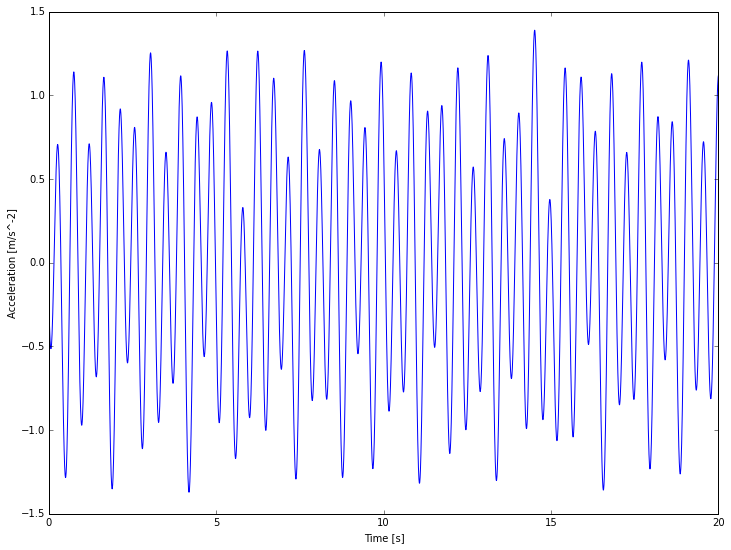

In [12]:
plt.plot(time, accel)
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s^-2]')

Now we generate a function that evaluates the right hand side of the closed loop system:

$$\dot{\mathbf{x}} = \mathbf{f}_c(\mathbf{x}, \mathbf{r}_k, \mathbf{p}_k, \mathbf{p}_u, t)$$

In [13]:
rhs, r, p = model.closed_loop_ode_func(time, ref_noise, accel)
help(rhs)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, r, p)
    
    Parameters
    x : ndarray, shape(4,)
        The state vector is ordered as such:
            - theta_a(t)
            - theta_h(t)
            - omega_a(t)
            - omega_h(t)
    t : float
        The current time.
    r : ndarray, shape(3,)
    
        A ndarray with the specified values in the correct order and of the
        correct shape.
    
        The specified inputs are, in order:
            - a(t)
            - T_h(t)
            - T_a(t)
    p : ndarray shape(8,)
        A ndarray of floats that give the numerical values of the constants in
        this order:
                - l_L
            - d_L
            - d_T
            - m_L
            - m_T
            - I_L
            - I_T
            - g
    
    Re

The system can be simulated by integrating the right hand side through time, given some initial condition.

In [14]:
x0 = np.zeros(len(model.states()))

In [15]:
x = odeint(rhs, x0, time, args=(r, p))

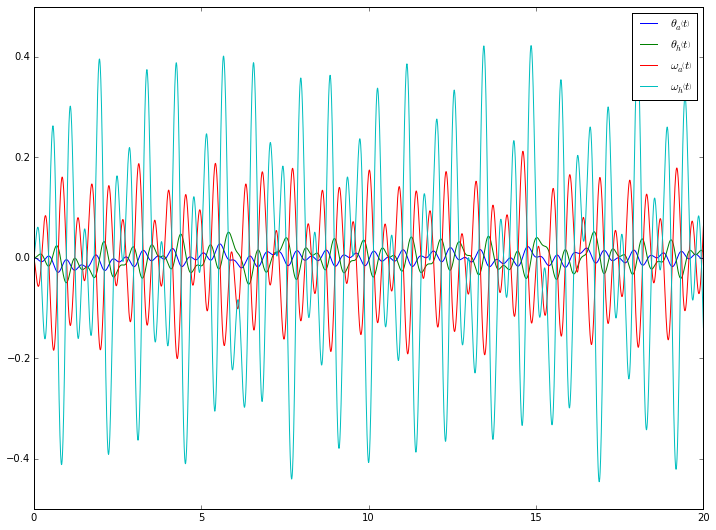

In [16]:
plt.plot(time, x)
plt.legend([sm.latex(s, mode='inline') for s in model.states()])

Now we add measurement noise to these simulated trajectories.

In [17]:
accel_meas = accel + np.random.normal(scale=np.deg2rad(0.25), size=accel.shape)

In [18]:
x_meas = x + np.random.normal(scale=np.deg2rad(0.25), size=x.shape)

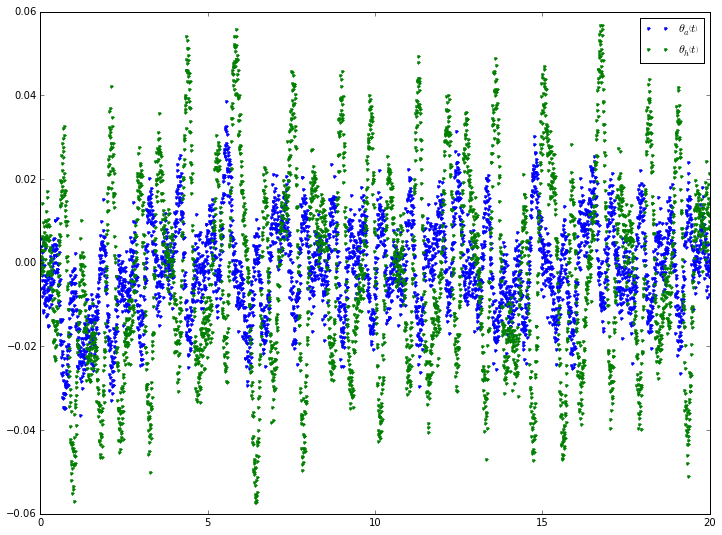

In [19]:
plt.plot(time, x_meas[:, :2], '.')
plt.legend([sm.latex(s, mode='inline') for s in model.states()])

# Define the objective

$$\min\limits_\theta J(\mathbf{\theta}), \quad
J(\mathbf{\theta})= \sum_{i=1}^N h [\mathbf{x}_{mi} - \mathbf{x}_i]^2$$

In [20]:
x_meas_vec = x_meas.T.flatten()

In [21]:
def obj(free):
    return interval * np.sum((x_meas_vec - free[:4 * num_nodes])**2)

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:4 * num_nodes] = 2.0 * interval * (free[:4 * num_nodes] - x_meas_vec)
    return grad

# Define bounds on the gains

In [22]:
bounds = {}
for g in model.gain_symbols:
    bounds[g] = (0.0, 1.0)
bounds

{k₀₀: (0.0, 1.0), k₀₁: (0.0, 1.0), k₀₂: (0.0, 1.0), k₀₃: (0.0, 1.0), k₁₀: (0.0
, 1.0), k₁₁: (0.0, 1.0), k₁₂: (0.0, 1.0), k₁₃: (0.0, 1.0)}

# Initialize the problem

In [23]:
prob = Problem(obj, obj_grad,
               model.first_order_implicit(),
               model.states(),
               num_nodes,
               interval,
               known_parameter_map=model.closed_loop_par_map,
               known_trajectory_map={model.specified['platform_acceleration']: accel_meas},
               bounds=bounds,
               time_symbol=model.time,
               integration_method='midpoint')

Set additional options for IPOPT

In [24]:
prob.addOption('linear_solver', 'ma57')

The initial guess can be:

$$\mathbf{\theta}_0 = [\mathbf{x}_{m1}, \ldots, \mathbf{x}_{mN}, \mathbf{0}]$$

But it can also solve from:

$$\mathbf{\theta}_0 = \mathbf{0}$$

In [25]:
#initial_guess = np.hstack((x_meas_vec, np.zeros(8)))
initial_guess = np.zeros(prob.num_free)

# Solve the problem

In [26]:
solution, info = prob.solve(initial_guess)

In [27]:
x_sol, r_sol, p_sol = parse_free(solution, len(model.states()), 0, num_nodes)

In [28]:
print("Gain initial guess: {}".format(model.gain_scale_factors.flatten() * initial_guess[-8:]))

Gain initial guess: [ 0.  0.  0.  0.  0.  0.  0.  0.]


In [29]:
print("Known value of p = {}".format(model.numerical_gains.flatten()))

Known value of p = [ 950.  175.  185.   50.   45.  290.   60.   26.]


In [30]:
print("Identified value of p = {}".format(model.gain_scale_factors.flatten() * p_sol))

Identified value of p = [ 947.77492904  173.66745739  185.12855097   49.82707837   44.14240269
  289.58708362   60.04449855   25.95846021]


# Plots

The trajectories of the states fit the measured data.

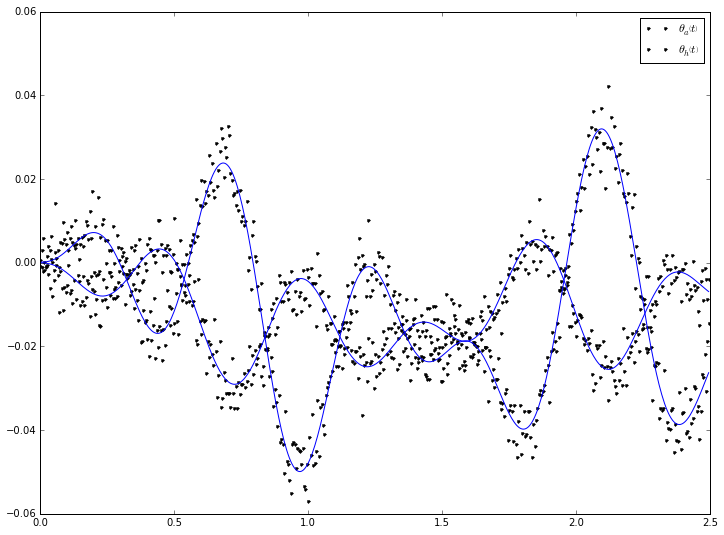

In [31]:
plt.plot(time[:500], x_meas[:500, :2], '.k', time[:500], x_sol.T[:500, :2], 'b')
plt.legend([sm.latex(s, mode='inline') for s in model.states()[:2]])